# Getting started with mapclassify.greedy

Greedy or topological coloring (or sequential coloring) is a cartographic method of assigning colors to polygons (or other geoemtries, `mapclassify.greedy` supports all geometry types) in such a way, that no two adjacent polygons share the same color.

`greedy` is a small toolkit within `mapclassify` providing such a functionality on top of GeoPandas GeoDataFrames. `mapclassify.greedy()` is all we need.

In [1]:
import geopandas as gpd

from mapclassify import greedy

Few of `greedy`'s methods of coloring require either measuring of areas or distances. To obtain proper values, our GeoDataFrame needs to be in projected CRS. Let's use Africa and reproject it to 'ESRI:102022':

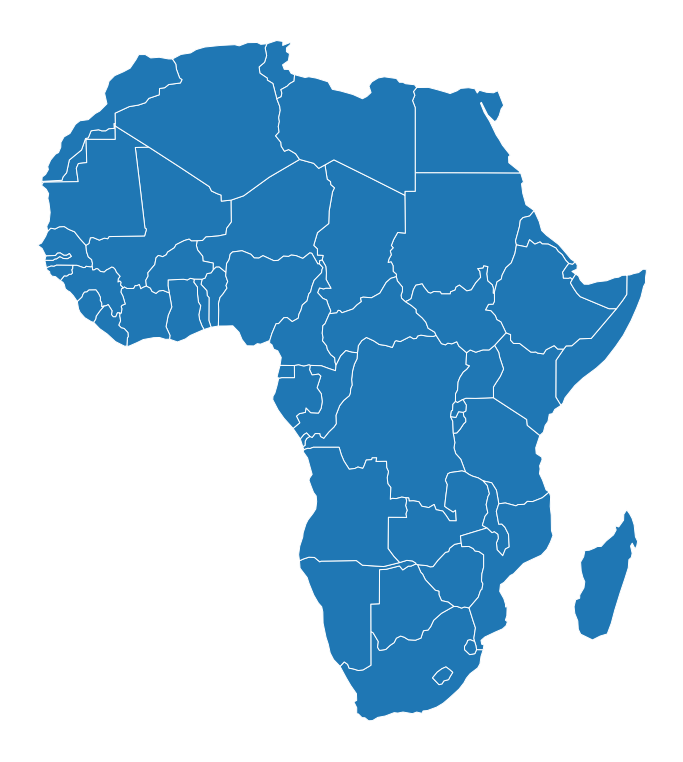

In [2]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = world.loc[world.continent == 'Africa']
africa = africa.to_crs('ESRI:102022')
ax = africa.plot(figsize=(12, 16), edgecolor='w')
ax.set_axis_off()

## Default

The default usage of `greedy` is extremely simple. Greedy returns Series with color codes, so we can assign it directly as a new column of our GeoDataFrame:

In [3]:
africa['greedy_default'] = greedy(africa)
africa['greedy_default'].head(5)

1     1
2     0
11    0
12    1
13    4
Name: greedy_default, dtype: int64

Using resulting color codes as plotting categories gives us following plot:

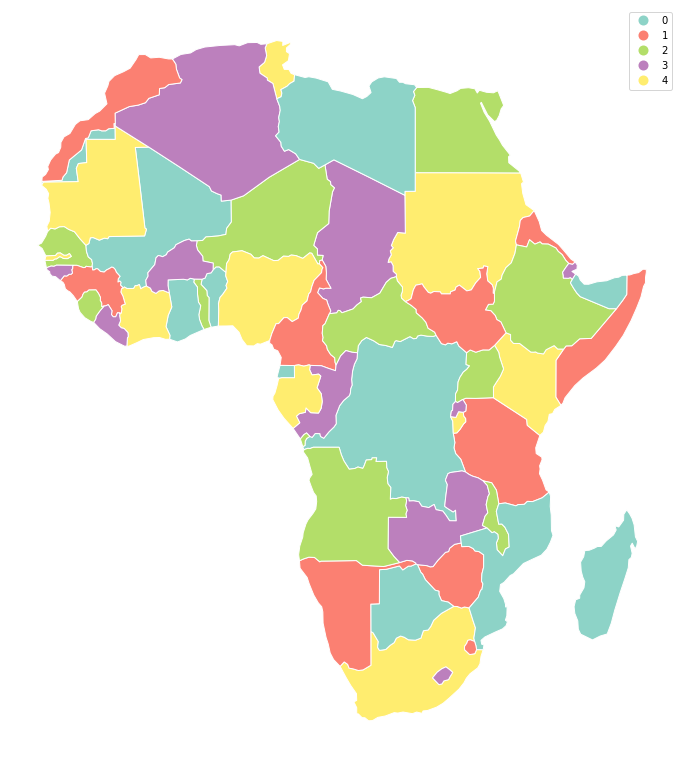

In [4]:
ax = africa.plot('greedy_default', categorical=True, figsize=(12, 16), cmap='Set3', legend=True, edgecolor='w')
ax.set_axis_off()

## Strategies

### Balanced

Greedy offers several strategies of coloring. The default strategy is `balanced` based on `count` attempting to balance the number of features per each color. Other balanced modes are `area` (balance the area covered by each color), `distance` and `centroid` (both attemtps to balance the distance between colors). Each of them attempts to balance the color assignemnt according to different conditions and hence can result in a different number of colors.

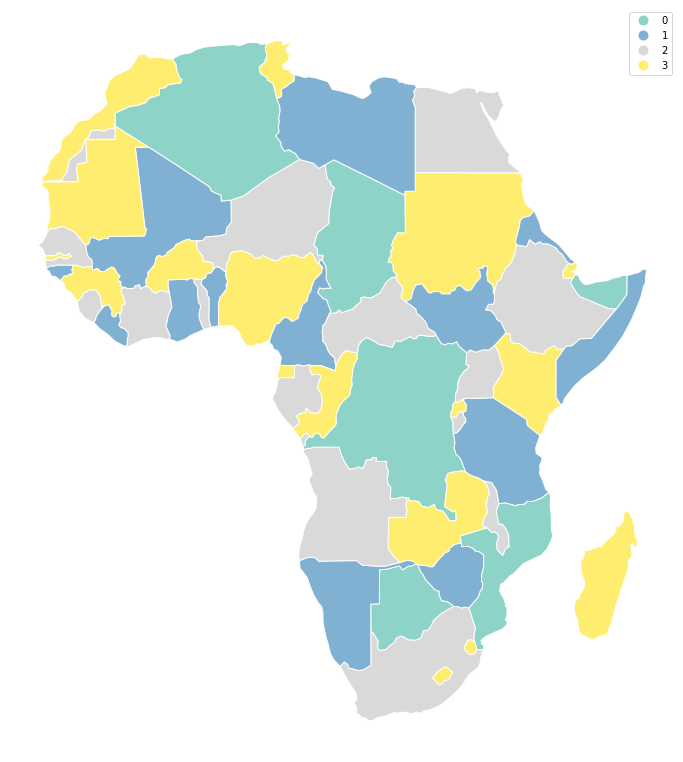

In [5]:
africa['greedy_area'] = greedy(africa, strategy='balanced', balance='area')
ax = africa.plot('greedy_area', categorical=True, figsize=(12, 16), cmap='Set3', legend=True, edgecolor='w')
ax.set_axis_off()

Different modes of balancing within `balanced` strategy can be set using `balance` keyword.

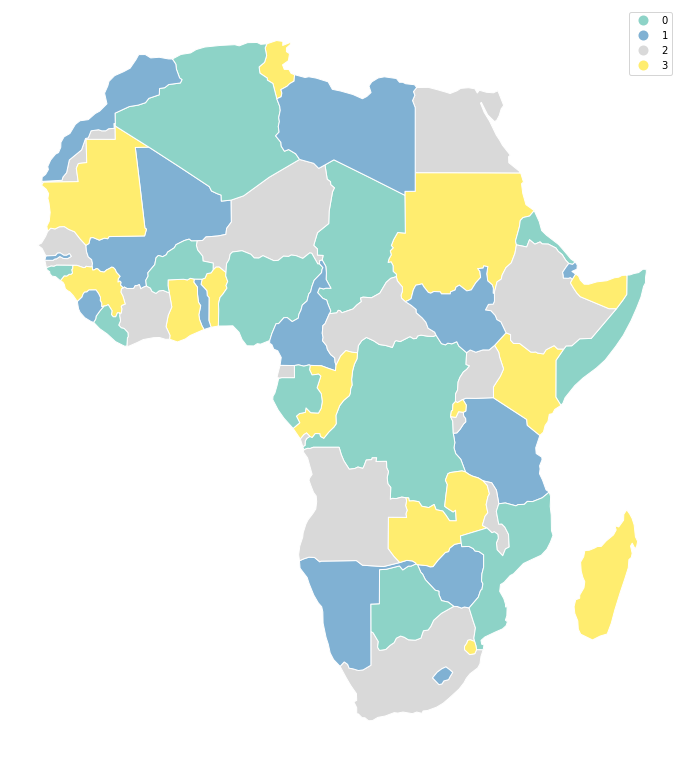

In [6]:
africa['greedy_distance'] = greedy(africa, strategy='balanced', balance='distance')
ax = africa.plot('greedy_distance', categorical=True, figsize=(12, 16), cmap='Set3', legend=True, edgecolor='w')
ax.set_axis_off()

## NetworkX strategies

On top of four modes of balanced coloring strategy, `greedy` offers all `networkx.greedy_coloring()` strategies, like `largest_first`:

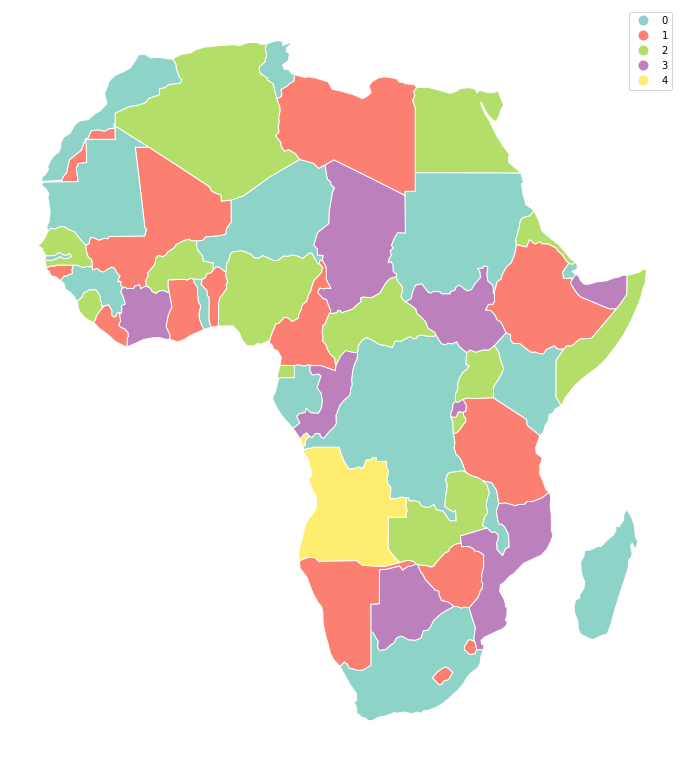

In [7]:
africa['greedy_largest_first'] = greedy(africa, strategy='largest_first')
ax = africa.plot('greedy_largest_first', categorical=True, figsize=(12, 16), cmap='Set3', legend=True, edgecolor='w')
ax.set_axis_off()

Another strategy provided by networkX is `smallest_last`. All strategies provide different results. Check Comparison of strategies below for details.

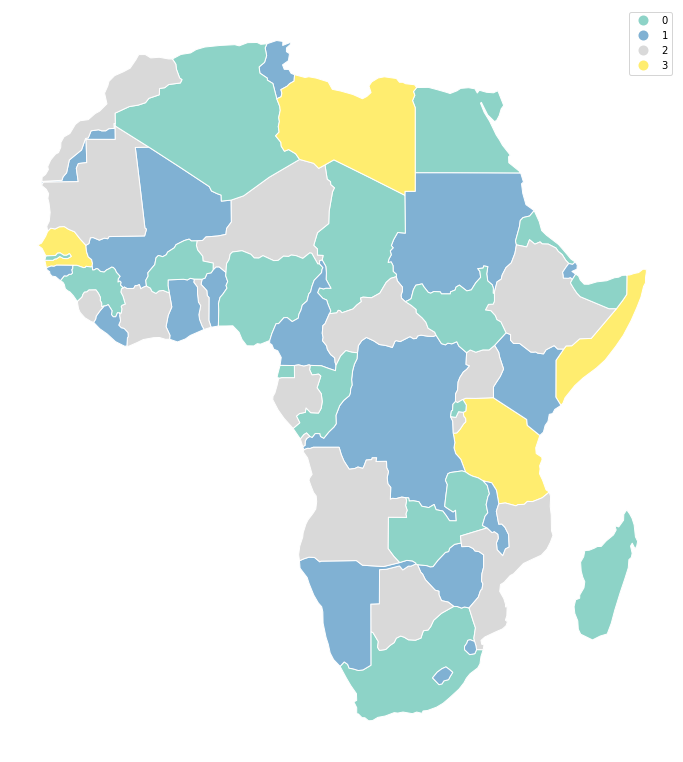

In [8]:
africa['greedy_s'] = greedy(africa, strategy='smallest_last')
ax = africa.plot('greedy_s', categorical=True, figsize=(12, 16), cmap='Set3', legend=True, edgecolor='w')
ax.set_axis_off()

Greedy is variable in a way how to define adjacency and which coloring strategy to use. All options are described in this documentation together with comparison of their performance.

## Defining adjacency

The key in toplogical coloring is the definition of adjacency, to understand which features are neighboring and could not share the same color. `mapclassify.greedy` comes with several methods of defining it. Binary spatial weights denoting adjacency are then stored as libpysal's weight objects.

In [9]:
import pandas as pd
import numpy as np
from time import time
import seaborn as sns
import matplotlib.pyplot as plt

from shapely.geometry import Point

sns.set()

For illustration purposes, let's generate a 10x10 mesh of squared polygons:

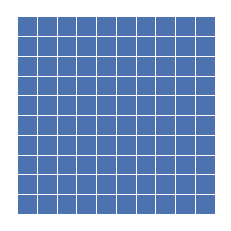

In [10]:
polys = []
for x in range(10):
    for y in range(10):
        polys.append(Point(x, y).buffer(0.5, cap_style=3))
gdf = gpd.GeoDataFrame(geometry=polys)
ax = gdf.plot(edgecolor='w')
ax.set_axis_off()

### libpysal adjacency

The most performant way of generating spatial weights is using libpysal contiguity weights. As they are based on the shared nodes or edges, dataset needs to be topologically correct. Neighboring polygons needs to share vertices and edges, otherwise their relationship will not be captured.

#### Rook

There are two ways how to define contiguity weights - `rook` and `queen`. Rook identifies two objects as neighboring only if they share at least on edge - line between two shared points. Use rook if you do not mind two polygons touching by hteir corners having the same color:

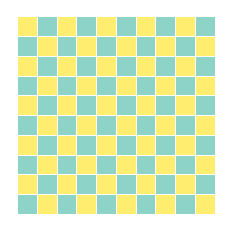

In [11]:
gdf['rook'] = greedy(gdf, sw='rook', min_colors=2)
ax = gdf.plot('rook', edgecolor='w', categorical=True, cmap='Set3')
ax.set_axis_off()

#### Queen

The default option in `greedy` is `queen` adjacency. That identifies two objects as neighboring if they share at least one point. It ensures that even poygons sharing only one corner will not share a color:

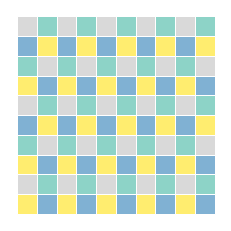

In [12]:
gdf['queen'] = greedy(gdf, sw='queen', min_colors=2)
ax = gdf.plot('queen', edgecolor='w', categorical=True, cmap='Set3')
ax.set_axis_off()

### Intersection-based adjacency

As noted above, if the topology of the dataset is not ideal, libpysal might not identify two visually neighboring features as neighbors. `greedy` can use intersection-based algorithm using GEOS intersection to define if two features intersects in any way. They do not have to share any points. Naturally, such an approach is significantly slower (details below), but it can provide correct adjacency when libpysal fails.

To make `greedy` to use this algorithm, one just needs to define `min_distance`. If it is set to 0, it behaves similarly to `queen` contiguity, just capturing all intersections:

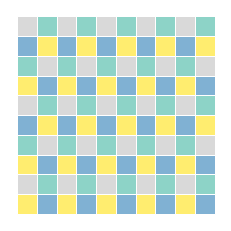

In [13]:
gdf['geos'] = greedy(gdf, min_distance=0, min_colors=2)
ax = gdf.plot('geos', edgecolor='w', categorical=True, cmap='Set3')
ax.set_axis_off()

`min_distance` also sets the minimal distance between colors. To do that, all features within such a distance are identified as neighbors, hence no two features wihtin set distance can share the same color:

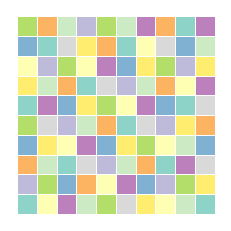

In [14]:
gdf['dist1'] = greedy(gdf, min_distance=1, min_colors=2)
ax = gdf.plot('dist1', edgecolor='w', categorical=True, cmap='Set3')
ax.set_axis_off()

### Reusing spatial weights

Passing `libpysal.weights.W` object to `sw`, will skip generating spatial weights and use the passed object instead. That will improve the performance if one intends to repeate the coloring multiple times. In that case, weights should be denoted using GeodataFrame's index.

### Performance

The difference in performance of libpysal and GEOS-based method is large, so it is recommended to use libpysal if possible. Details of comparison between all methods are below:

In [15]:
times = pd.DataFrame(index=['rook', 'queen', 'geos', 'dist1'])
for number in range(10, 110, 10):
    print(number)
    polys = []
    for x in range(number):
        for y in range(number):
            polys.append(Point(x, y).buffer(0.5, cap_style=3))
    gdf = gpd.GeoDataFrame(geometry=polys)
    timer = []
    for run in range(5):
        s = time()
        colors = greedy(gdf, sw='rook', min_colors=2)
        e = time() - s
        timer.append(e)
    times.loc['rook', number] = np.mean(timer)
    print('rook: ', np.mean(timer), 's; ', np.max(colors) + 1, 'colors')
    timer = []
    for run in range(5):
        s = time()
        colors = greedy(gdf, sw='queen', min_colors=2)
        e = time() - s
        timer.append(e)
    times.loc['queen', number] = np.mean(timer)
    print('queen: ', np.mean(timer), 's; ', np.max(colors) + 1, 'colors')
    timer = []
    for run in range(5):
        s = time()
        colors = greedy(gdf, min_distance=0, min_colors=2)
        e = time() - s
        timer.append(e)
    times.loc['geos', number] = np.mean(timer)
    print('geos: ', np.mean(timer), 's; ', np.max(colors) + 1, 'colors')
    timer = []
    for run in range(5):
        s = time()
        colors = greedy(gdf, min_distance=1, min_colors=2)
        e = time() - s
        timer.append(e)
    times.loc['dist1', number] = np.mean(timer)
    print('dist1: ', np.mean(timer), 's; ', np.max(colors) + 1, 'colors')

10
rook:  0.012784147262573242 s;  2 colors
queen:  0.005277395248413086 s;  4 colors
geos:  0.09882774353027343 s;  4 colors
dist1:  0.13624219894409179 s;  10 colors
20
rook:  0.014943456649780274 s;  2 colors
queen:  0.013994264602661132 s;  4 colors
geos:  0.39907083511352537 s;  4 colors
dist1:  0.547985029220581 s;  10 colors
30
rook:  0.045798969268798825 s;  2 colors
queen:  0.03402729034423828 s;  4 colors
geos:  0.9942648410797119 s;  4 colors
dist1:  1.3713165283203126 s;  10 colors
40
rook:  0.07214193344116211 s;  2 colors
queen:  0.06085910797119141 s;  4 colors
geos:  1.7829225063323975 s;  4 colors
dist1:  2.3820394039154054 s;  10 colors
50
rook:  0.11196293830871581 s;  2 colors
queen:  0.10349822044372559 s;  4 colors
geos:  2.5976396560668946 s;  4 colors
dist1:  3.596402406692505 s;  10 colors
60
rook:  0.1528311252593994 s;  2 colors
queen:  0.1566312789916992 s;  4 colors
geos:  3.7294684410095216 s;  4 colors
dist1:  5.268119859695434 s;  10 colors
70
rook:  0.2

([<matplotlib.axis.XTick at 0x7f7d5299db10>,
 [Text(0, 0, '100'),
  Text(0, 0, '400'),
  Text(0, 0, '900'),
  Text(0, 0, '1600'),
  Text(0, 0, '2500'),
  Text(0, 0, '3600'),
  Text(0, 0, '4900')])

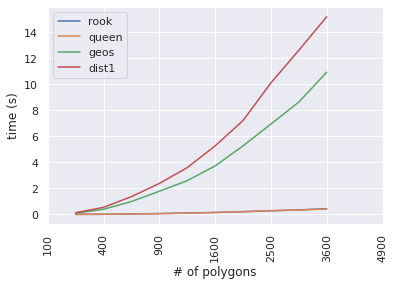

In [16]:
ax = times.T.plot()
ax.set_ylabel('time (s)')
ax.set_xlabel('# of polygons')
locs, labels = plt.xticks()
plt.xticks(locs, (times.columns ** 2), rotation='vertical')

Plotting without the GEOS methods, the difference between `queen` and `rook` is minimal:

([<matplotlib.axis.XTick at 0x122684880>,
 [Text(0, 0, '100'),
  Text(0, 0, '400'),
  Text(0, 0, '900'),
  Text(0, 0, '1600'),
  Text(0, 0, '2500'),
  Text(0, 0, '3600'),
  Text(0, 0, '4900')])

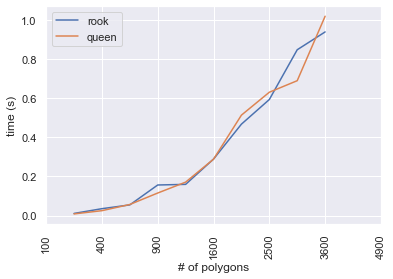

In [17]:
ax = times.loc[['rook', 'queen']].T.plot()
ax.set_ylabel('time (s)')
ax.set_xlabel('# of polygons')
locs, labels = plt.xticks()
plt.xticks(locs, (times.columns ** 2), rotation='vertical')

## Comparison of strategies

Different coloring strategies lead to different results, but also have different performance. It all depends on preferences, what is the goal. 

If one want visually balanced result, `'balanced'` strategy could be the right choice. It comes with four different modes of balancing - `'count'`, `'area'`, `'distance'`, and `'centroid'`. The first one attempts to balance the number of features per each color, second the area covered by each color, and two last based on the distance between features. Either represented by the geometry itself or its centroid (a bit faster).

Other strategies might be helpful if one wants to minimise number of colors as not all strategies use the same amount in the end. Or they just might look better on your map.

Below is a comparison of performance and the result of each of the strategies supported by `greedy`.

In [18]:
import libpysal

When using `'balanced'` strategy with `'area'`, `'distance'`, or `'centroid'` modes, keep in mind that your data needs to be in projected CRS to obtain correct results. For the simplicity of this comparison, let's pretend that dataset below is (even though it is not).

Strategies used in `mapclassify.greedy` have two origins - `'balanced'` is ported from QGIS while the rest comes from `networkX`. Snippet below generates each option 20x and returns the mean time elapsed together with the number of colors used.

In [19]:
strategies = ['balanced', 'largest_first', 'random_sequential', 'smallest_last',
              'independent_set', 'connected_sequential_bfs', 'connected_sequential_dfs',
              'saturation_largest_first']
balanced_modes = ['count', 'area', 'centroid', 'distance']

times = {}
sw = libpysal.weights.Queen.from_dataframe(
                world, ids=world.index.to_list(), silence_warnings=True
            )
for strategy in strategies:
    if strategy == 'balanced':
        for mode in balanced_modes:
            print(strategy, mode)
            timer = []
            for run in range(20):
                s = time()
                colors = greedy(world, strategy=strategy, balance=mode, sw=sw)
                e = time() - s
                timer.append(e)
            world[strategy + '_' + mode] = colors
            times[strategy + '_' + mode] = np.mean(timer)
            print('time: ', np.mean(timer), 's; ', np.max(colors) + 1, 'colors')
    else:
        print(strategy)
        timer = []
        for run in range(20):
            s = time()
            colors = greedy(world, strategy=strategy, sw=sw)
            e = time() - s
            timer.append(e)
        world[strategy] = colors
        times[strategy] = np.mean(timer)
        print('time: ', np.mean(timer), 's; ', np.max(colors) + 1, 'colors')

balanced count
time:  0.0012734532356262207 s;  5 colors
balanced area
time:  0.04488915205001831 s;  5 colors
balanced centroid
time:  0.6184169292449951 s;  5 colors
balanced distance
time:  3.698784148693085 s;  5 colors
largest_first
time:  0.00743335485458374 s;  5 colors
random_sequential
time:  0.0073337554931640625 s;  5 colors
smallest_last
time:  0.012673044204711914 s;  4 colors
independent_set
time:  0.21364336013793944 s;  5 colors
connected_sequential_bfs
time:  0.010818779468536377 s;  5 colors
connected_sequential_dfs
time:  0.01690601110458374 s;  5 colors
saturation_largest_first
time:  0.04053806066513062 s;  4 colors


As you can see, `smallest_last` and `saturation_largest_first` were able, for this particular dataset, to generate greedy coloring using only 4 colors. If one wants to use higher number than the minimal, `'balanced'` strategy allows setting of `min_colors` to be used.

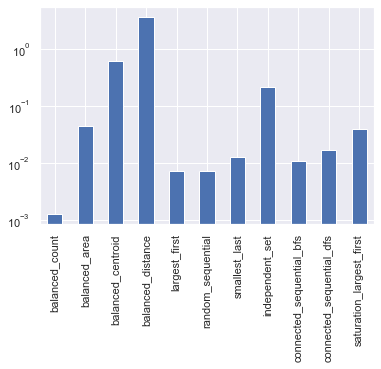

In [20]:
times = pd.Series(times)
ax = times.plot(kind='bar')
ax.set_yscale("log")

Plot above shows the performance of each strategy. Note that the vertical axis is using log scale.

Below are all results plotted on the map.

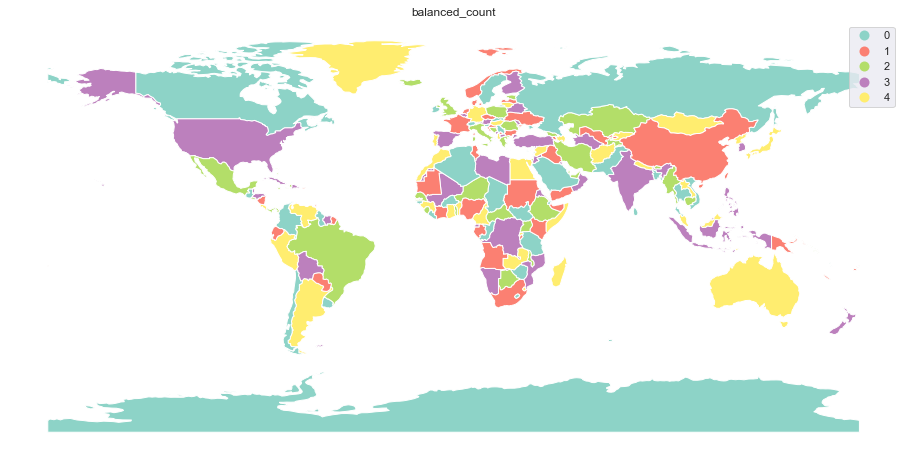

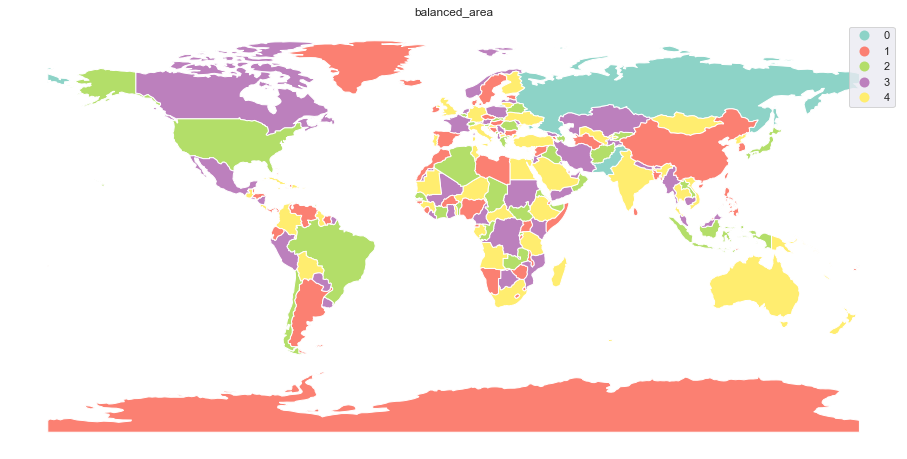

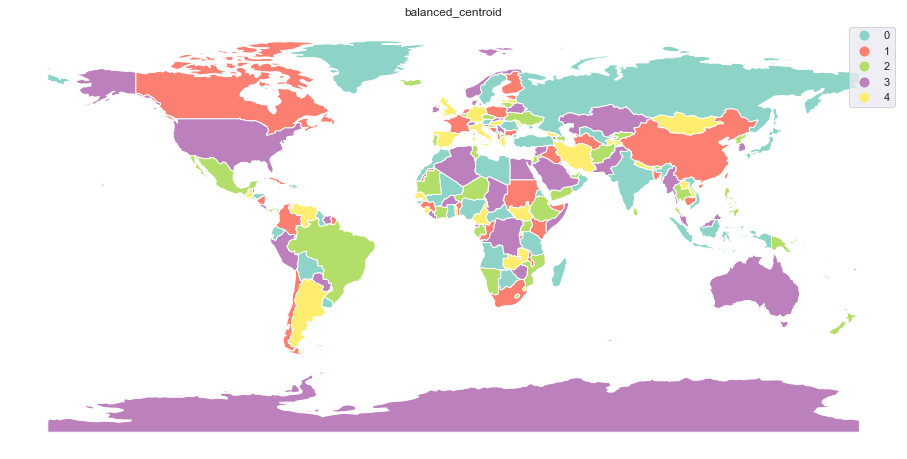

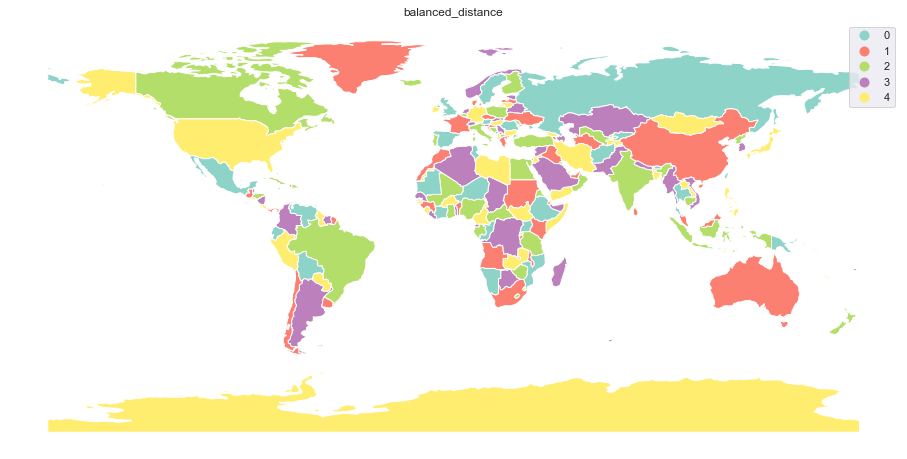

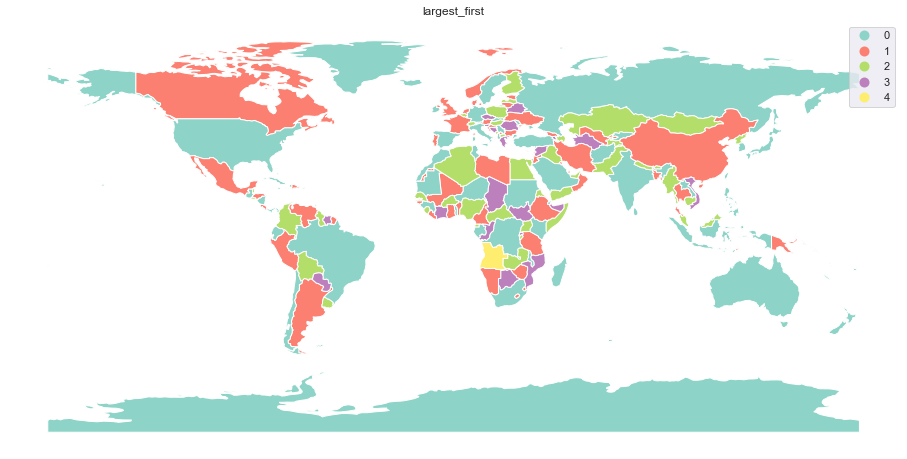

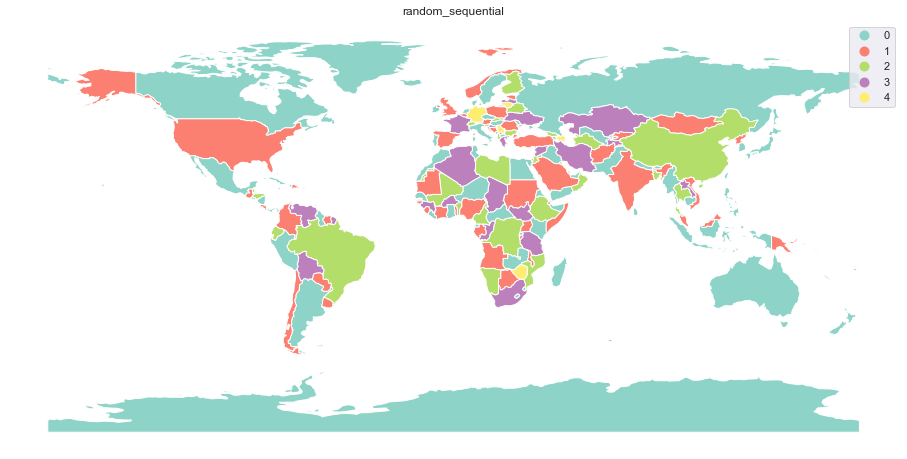

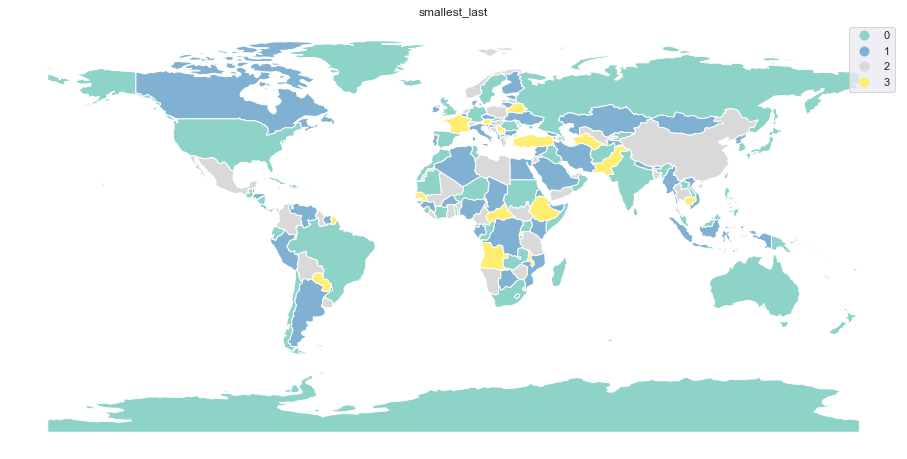

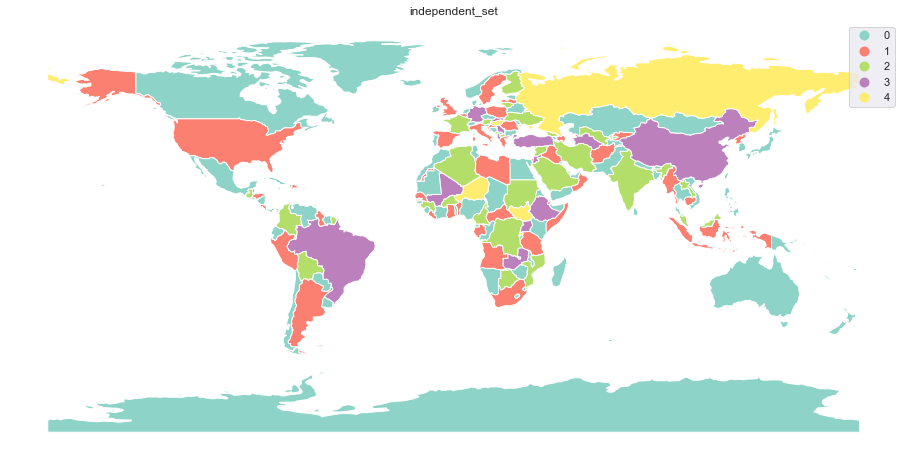

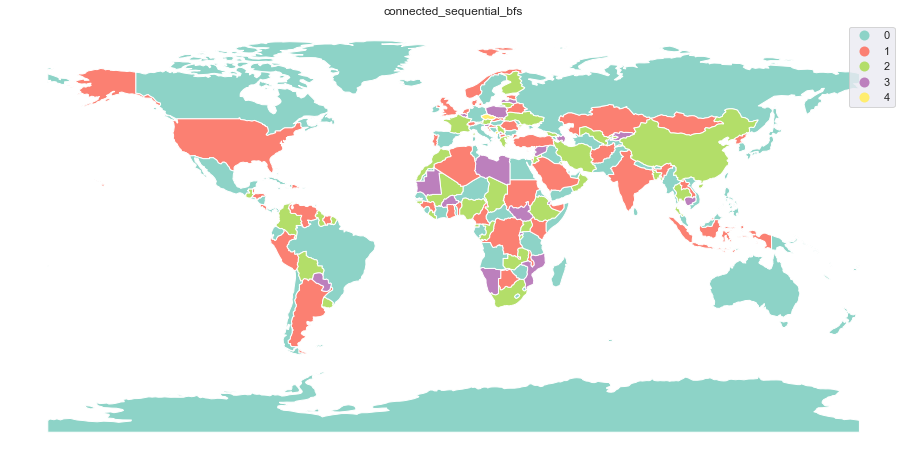

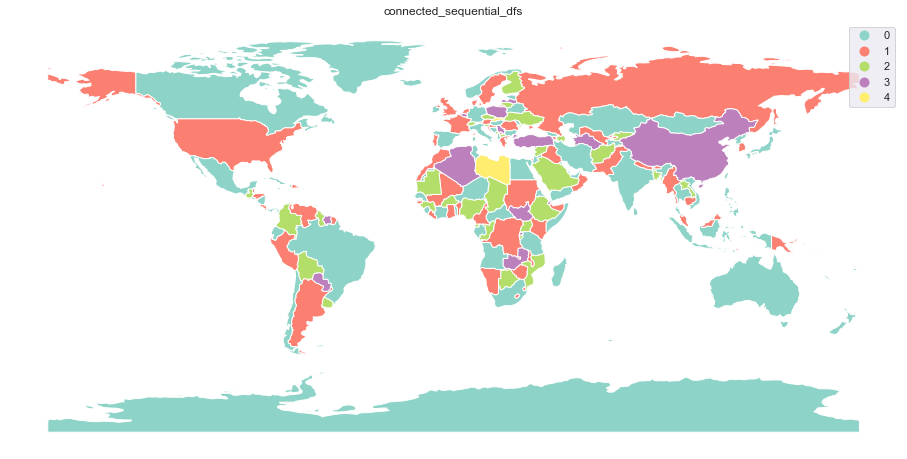

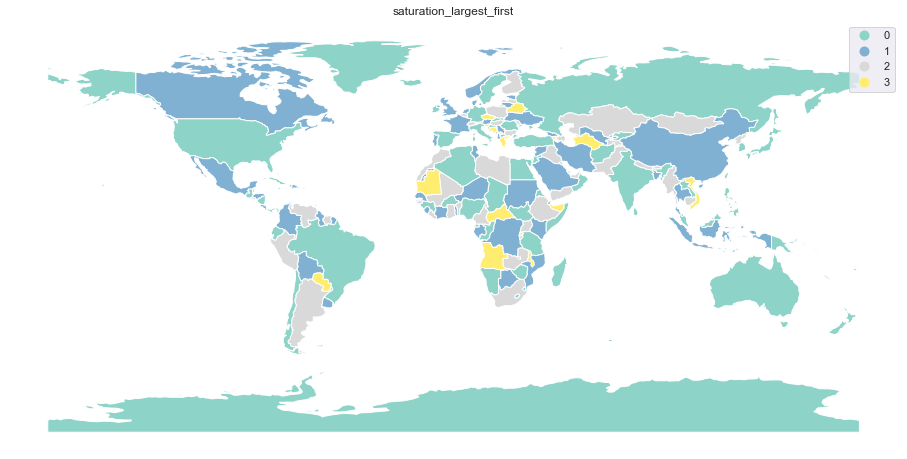

In [21]:
for strategy in times.index:
    ax = world.plot(strategy, categorical=True, figsize=(16, 12), cmap='Set3', legend=True)
    ax.set_axis_off()
    ax.set_title(strategy)